In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
import re
from datetime import datetime, date, timedelta
import numpy as np
import holidays
import os

When the card creation date is unknown, or is from a previous sprint, then we will use the sprint start date

In [3]:
sprint_dt_start = date(2018, 11, 5)
sprint_start = sprint_dt_start.strftime('%Y-%m-%dT%H:%M:%S.%fz')
'Brazil/East'
sprint_start

'2018-11-05T00:00:00.000000z'

Here we define the credentials for trello and the board where we will read the cards and lists

In [31]:
trello_key = os.environ['TRELLO_KEY']
trello_token = os.environ['TRELLO_TOKEN']
#Board for "Sprint BI"
trello_board = os.environ['TRELLO_BOARD']
# trello_key, trello_token, trello_board

First we get from Trello API the cards specifically from the board chosen

In [5]:
url_cards = 'https://api.trello.com/1/boards/{}/cards/?key={}&token={}'
url_cards = url_cards.format(trello_board, trello_key, trello_token)

r = requests.get(url_cards)
if r.status_code == 200:
    cards = r.json()

Then we get from the API the lists for this board

In [6]:
url_lists = 'https://api.trello.com/1/boards/{}/lists/?key={}&token={}'
url_lists = url_lists.format(trello_board, trello_key, trello_token)
r = requests.get(url_lists)
if r.status_code == 200:
    board_lists = r.json()

In [7]:
board_lists[0]

{'id': '5bd862d1d897812b5a51e40c',
 'name': 'SELECTED 4 WORK s. 45/46/47',
 'closed': False,
 'idBoard': '5b69af562c071844029c995c',
 'pos': 98303,
 'subscribed': False}

For each card we request from the API the last action of type 'updateCard' which contains information regarding the change of board. If it's unknown we set the sprint_start for this column

In [8]:
url_card_list = 'https://api.trello.com/1/cards/{}/actions?filter=updateCard:idList&limit=1&key={}&token={}'

for c in cards:
    url_card_info = url_card_list.format(c['id'], trello_key, trello_token)

    r = requests.get(url_card_info)
    if r.status_code == 200:
        card_info = r.json()
        if card_info is None or len(card_info) < 1:
            c['last_move_date'] = sprint_start
        else:
            c['last_move_date'] = card_info[0]['date']
    

Also for each card we request the action 'createCard' which contains the card creation date. If it is unknown or the date is before the sprint_start then we use the sprint_start.

In [9]:
url_card_createdat = 'https://api.trello.com/1/cards/{}/actions?filter=createCard&key={}&token={}'

for c in cards:
    url_card_info = url_card_createdat.format(c['id'], trello_key, trello_token)

    r = requests.get(url_card_info)
    if r.status_code == 200:
        card_info = r.json()
        if card_info is None or len(card_info) < 1:
            c['create_date'] = sprint_start
        else:
            dt = card_info[0]['date']
            c['create_date'] = sprint_start if dt < sprint_start else dt
                

Create columns urgent and unplanned after the labels contained in the card. Convert types of columns urgent, unplanned, last_move_date, create_date and task.

In [10]:
cols = ['task', 'urgent', 'unplanned', 'idList', 'create_date', 'last_move_date']
df = pd.DataFrame(columns=cols)

for c in cards:    
    labels = [l['name'] for l in c['labels']]
    
    df.loc[len(df)] = [
        c['name'], 'URGENT' in labels, 'UNPLANNED' in labels,
        c['idList'], c['create_date'], c['last_move_date']]

df.loc[:, 'task'] = df.loc[:, 'task'].astype(str)
df[['create_date']] = pd.to_datetime(df[['create_date']].stack(), format='%Y-%m-%dT%H:%M:%S.%fz').unstack()
df[['last_move_date']] = pd.to_datetime(df[['last_move_date']].stack(), format='%Y-%m-%dT%H:%M:%S.%fz').unstack()
df['urgent'] = df['urgent'].astype(bool)
df['unplanned'] = df['unplanned'].astype(bool)

Build a dictionary for the board lists (that aren't closed).

In [11]:
lists = {}
[lists.update({l['id']: l['name']}) for l in board_lists if not l['closed']]
lists

{'5bd862d1d897812b5a51e40c': 'SELECTED 4 WORK s. 45/46/47',
 '5b69af899acf9455c04de971': 'IN PROGRESS',
 '5be06e0c529ba20cc35b300a': 'RDY s.45/46/47 [+novo em baixo]',
 '5be09a24bfa4ab748545db89': 'DONE s. 45/46/47',
 '5b69af6b330f5263a8bc217e': 'REGRAS',
 '5be8f3675e20bb6c618fdaab': 'CHARTS'}

Match lists' names to find if it is type 'SELECTED', 'RDY', 'DONE' and 'IN PROGRESS', and also the sprint for the list (which is either 1 number or 2 separated by "/"). A dataframe is created with the idList, sprint discovered and status.
Lists with different names, such as "Regras", are ignored.

In [12]:
#FIXME: Remove this double equals?
cols = columns=['idList', 'sprint', 'status']
df_lists = pd.DataFrame(columns=cols)

sprint_name = None

for k, v in lists.items():
#     print((k, v))
    sprint = None
    
    match = re.search('^SELECTED.*([0-9]{2})(/[0-9]{2})', v)
    status = 'SELECTED'
    if match is None:
        match = re.search('^SELECTED.*([0-9]{2})', v)
        status = 'SELECTED'
        
    if match is None:
        match = re.search('^RDY.*([0-9]{2})(/[0-9]{2})', v)
        status = 'RDY'
    if match is None:
        match = re.search('^RDY.*([0-9]{2})', v)
        status = 'RDY'
        
    if match is None:
        match = re.search('^DONE.*([0-9]{2})(/[0-9]{2})', v)
        status = 'DONE'
    if match is None:
        match = re.search('^DONE.*([0-9]{2})', v)
        status = 'DONE'
        
    if match is None:
        match = re.search('IN PROGRESS', v)
        status = 'IN PROGRESS'
        sprint = ''
        
    # If cannot match anything, the this list doesn't matter
    if match is None:
        continue
    
    # If a match has happened and sprint is None, then get the sprint for the list
    # "IN PROGRESS" match fill it with empty space because it doesn't come with sprint
    if match is not None and sprint is None:
        sprint = match.group(1)
        # print(match.groups())
        if len(match.groups()) > 1 and match.group(2) is not None:
            sprint += match.group(2)
            
        # Get sprint name just to use later in the plot
        if not sprint_name:
            sprint_name = sprint
    
    # Add to df_lists 
    if sprint is not None:
        df_lists.loc[len(df_lists)] = [k, sprint, status]
    
# print(df_lists.loc[:,:])
df_lists

,idList,sprint,status
0,5bd862d1d897812b5a51e40c,46/47,SELECTED
1,5b69af899acf9455c04de971,,IN PROGRESS
2,5be06e0c529ba20cc35b300a,46/47,RDY
3,5be09a24bfa4ab748545db89,46/47,DONE


Join the dataframe df with the lists dataframe by idList column, into the df variable.

In [13]:
df = df_lists.join(df.set_index('idList'), on='idList', rsuffix='_2')

Normalize the date columns into day columns

In [14]:
df['create_day'] = pd.to_datetime(df['create_date']).dt.normalize()
df['last_move_day'] = pd.to_datetime(df['last_move_date']).dt.normalize()

Remove EPIC tasks from dataframe.

In [15]:
df = df[df['task'].str.extract('(EPIC)').isna()[0]]

Extract from task name the value for expected and final, and created the respective column for each task

In [16]:
df.loc[:, 'expected'] = df['task'].str.extract('^\((\d*\.\d+|\d+|\?)+\).*', expand=False)
df.loc[:, 'final'] = df['task'].str.extract('\[(\d*\.\d+|\d+)+\]$', expand=False)

# df['expected'] = df['task'].str.extract('^\((\d*\.\d+|\d+|\?)+\).*')
# df['final'] = df['task'].str.extract('\[(\d*\.\d+|\d+)+\]$')
df[['task', 'expected', 'final']]

,task,expected,final
0,"(5) [MTZ] Pegar, organizar, armazenar dados de...",5,NaN
0,(3) [MTZ] view Mobile Compare Period Dashboard...,3,NaN
0,(8) [MKT] Captar dados do AppAnnie em maior gr...,8,NaN
0,(5) Investigar a demora do Vacuum do redshift,5,NaN
0,(?) atraso nos dados de retenção do adjust,?,NaN
0,(3) Pegar installs store da Leela possível dup...,3,NaN
0,(2) 3. Persistir dados baixados,2,NaN
0,(0.5) 4. Deploy em PRD,0.5,NaN
0,Análise IronSrc,NaN,NaN
1,(?) [MKT] Extrair informações vindas por email...,?,3


Create dataframe dt_plot after the df to format the data for plotting. 

As the expected column may have "?" or NA value, we replace with the column with final points value. If the final column does not contain any value, then we drop these rows.

We create a "day" column and depending on the status of the task it's set differently. We consider the task in "RDY" or "DONE" as done, and the "SELECTED" and "IN PROCESS" as not done.

If the task is done but doesn't have any value in final column, we set it as the expected column. The remaining that are NA we set as zero.

The result is a dataframe with all expected and final values filled.

In [17]:
df_plot = df[['task', 'expected', 'final', 'create_day', 'last_move_day', 'status', 'sprint', 'unplanned']]

# Set missing expected points with final, if it exists
without_points = ((df_plot['expected'] == '?') | (df_plot['expected'].isna())) & (~df_plot['final'].isna())
df_plot.loc[without_points, 'expected'] = df_plot.loc[without_points, 'final']

# Drop when value of expected is NA or "?"
df_plot.dropna(subset=['expected'])
df_plot = df_plot[df_plot['expected'] != '?']

# sprint = df_plot.sprint.loc[df_plot.sprint.unique() != ''].sort_values(ascending=False)

df_plot = df_plot.set_index('task', drop=False)

#In case a task without final value is RDY or DONE, we fill final values with expected, 
#otherwise we fill it with zero
is_done = df_plot['status'].isin(['RDY', 'DONE'])
df_plot.loc[is_done, 'day'] = df_plot.loc[is_done, 'last_move_day']
df_plot.loc[~is_done, 'day'] = df_plot.loc[~is_done, 'create_day']
df_plot.loc[is_done, 'final'] = df_plot.loc[is_done, 'final'].fillna(df_plot['expected'])
df_plot.loc[:, 'final'] = df_plot['final'].fillna(0)

df_plot = df_plot.set_index('day', drop=False)

df_plot.loc[:, 'expected'] = pd.to_numeric(df_plot['expected'])
df_plot.loc[:, 'final'] = pd.to_numeric(df_plot['final'])

df_plot

/home/matheus/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,task,expected,final,create_day,last_move_day,status,sprint,unplanned,day
day,,,,,,,,,
2018-11-05,"(5) [MTZ] Pegar, organizar, armazenar dados de...",5.0,0,2018-11-05,2018-11-14,SELECTED,46/47,False,2018-11-05
2018-11-05,(3) [MTZ] view Mobile Compare Period Dashboard...,3.0,0,2018-11-05,2018-11-09,SELECTED,46/47,False,2018-11-05
2018-11-05,(8) [MKT] Captar dados do AppAnnie em maior gr...,8.0,0,2018-11-05,2018-11-09,SELECTED,46/47,False,2018-11-05
2018-11-05,(5) Investigar a demora do Vacuum do redshift,5.0,0,2018-11-05,2018-11-07,SELECTED,46/47,False,2018-11-05
2018-11-05,(3) Pegar installs store da Leela possível dup...,3.0,0,2018-11-05,2018-11-05,SELECTED,46/47,False,2018-11-05
2018-11-05,(2) 3. Persistir dados baixados,2.0,0,2018-11-05,2018-10-31,SELECTED,46/47,False,2018-11-05
2018-11-05,(0.5) 4. Deploy em PRD,0.5,0,2018-11-05,2018-10-31,SELECTED,46/47,False,2018-11-05
2018-11-12,Análise IronSrc,NaN,0,2018-11-12,2018-11-14,SELECTED,46/47,True,2018-11-12
2018-11-05,(?) [MKT] Extrair informações vindas por email...,3.0,3,2018-11-05,2018-11-13,IN PROGRESS,,True,2018-11-05


A new dataframe called df_group is created after the df_plot with the sum of final values and grouped by day.



In [18]:
# df_group = df_plot['expected'].groupby([df_plot['create_day']]).sum().to_frame()
df_group = pd.DataFrame(columns=['expected','final'],
                       index=pd.date_range(start=sprint_dt_start, periods=12, name='day'))
# df_group[:] = 0
# df_group.index = df_group.index.strftime('%Y-%m-%d')
df_group['expected'] = df_plot['expected'].groupby([df_plot['create_day']]).sum()
df_group['expected'] = df_group['expected'].fillna(0)

df_group['final'] = df_plot['final'].groupby(df_plot['last_move_day']).sum()
df_group['final'] = df_group['final'].fillna(0)

# df_group = df_group.sort_index(ascending=True)

#TODO: VERIFICAR SE TIVER VALOR final PARA AQUELA DATA E NÃO TIVER expected COM AQUELA CREATE_DATE 
#SE APARECE NO GROUP BY
df_group['expected'] = np.cumsum(df_group['expected'])
df_group['final'] = np.cumsum(df_group['final'])

# df_group[(df_group.index >= '2018-11-14'), 'expected']


In [19]:
#burndown stuff:

# df_group = df_plot['final'].groupby([df_plot.index]).sum().to_frame()
# df_group['final_3'] = df_plot['final_3'].groupby(df_plot.index).sum()

# df_planned = df_plot.loc[~df_plot['unplanned'].astype(bool), 'final_3']
# df_group['final_3_planned'] = df_planned.groupby(df_planned.index).sum()

# df_planned = df_plot.loc[~df_plot['unplanned'].astype(bool), 'expected_3']
# df_group['expected_3_planned'] = df_planned.groupby(df_planned.index).sum()

# df_group = df_group.sort_index(ascending=False)

# df_group['final'] = np.cumsum(df_group['final'])
# df_group['final_3'] = np.cumsum(df_group['final_3'])
# df_group['final_3_planned'] = np.cumsum(df_group['final_3_planned'])
# df_group['expected_3_planned'] = np.cumsum(df_group['expected_3_planned'])

# max_expected = df_plot.expected.sum()
# df_group['final_'] = max_expected - df_group['final']
# df_group['final_3_'] = max_expected - df_group['final_3']
# df_group['final_3_planned_'] = max_expected - df_group['final_3_planned']

# df_group

In [20]:
# xx = None
# if xx:
#     xx = np.concatenate([xx, np.linspace(start, end, num)])
# else:
#     xx = np.linspace(start, end, num)]



In [21]:
# dir(holidays.BR(state='RJ'))
# df_group.index.isin(holidays.BR(state='RJ').items())
# df_group.index.isin(holidays.BR(state='RJ'))
# df_group.reset_index().apply(lambda x: x if x not in holidays.BR(state='RJ') else None, axis=1)
df_group = df_group.reset_index().\
    apply(lambda x: x if x.day.date() not in holidays.BR(state='RJ') and x.day.dayofweek // 5 == 0 else None, axis=1).\
    dropna().\
    set_index('day')
df_group.index = df_group.index.strftime('%d-%m')
df_group

,expected,final
05-11,53.5,0.0
06-11,53.5,0.0
07-11,55.5,1.0
08-11,56.5,1.0
09-11,57.5,10.0
12-11,60.5,13.0
13-11,60.5,24.0
14-11,60.5,28.0
16-11,60.5,28.0


<IPython.core.display.Javascript object>


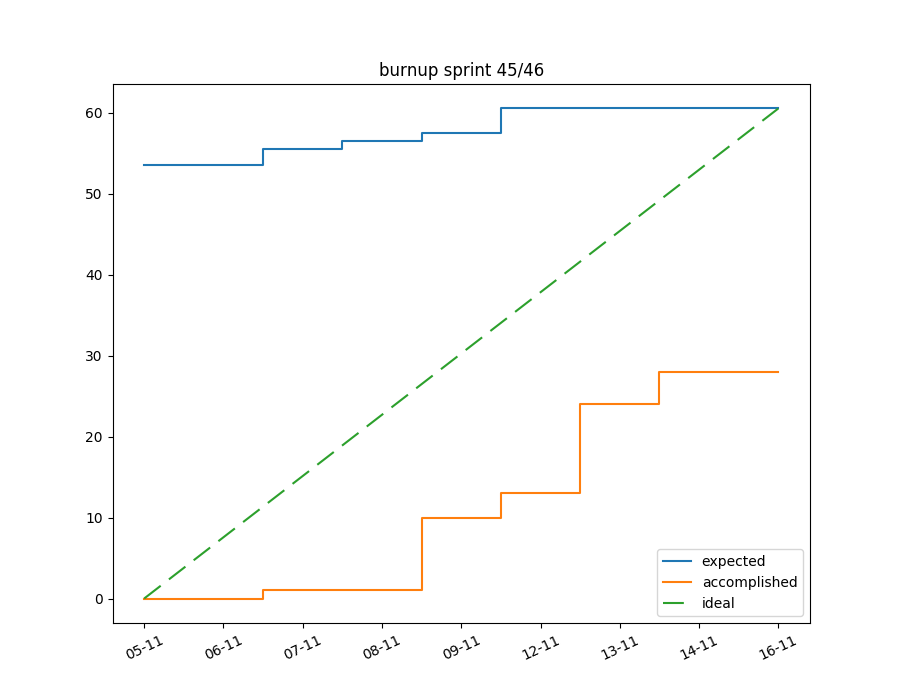

In [24]:
# # Discover weekends to draw a gray region 
# weekend_days = df_group.index.dayofweek // 5 == 1
# for day, values in df_group[weekend_days].iterrows():
#     df_group.drop(day)

# # Discover brazilian holidays (including Rio de Janeiro's) to draw a gray region
# for dt in df_group.index:
#     if dt in holidays.BR(state='RJ'):
#         df_group.drop(dt)

# df_group[df_group.index >= '2018-11-14'] = None
# df_group = df_group.dropna()

fig, ax = plt.subplots(figsize=[9, 7])
ax.plot(df_group.loc[:, ['expected', 'final']], drawstyle='steps-mid')
# plt.grid()
# ax.xaxis.grid(minor=True) # vertical lines
plt.xticks(rotation=25)

# start = pd.Timestamp(df_group.index.min()).value
# end = pd.Timestamp(df_group.index.max()).value
num = df_group.count()[0]

td = timedelta(hours=12)



# x = np.linspace(start, end, num)
# x = pd.to_datetime(x)
# x = x.apply(lambda x: x if x.day.date() not in holidays.BR(state='RJ') and x.day.dayofweek // 5 == 0 else None, axis=1)
# x = x.strftime('%d-%m')
x = df_group.index
y = np.linspace(0, df_group['expected'].max(), num)
ax.plot(x, y, dashes=[10, 5, 10, 5])

ax.legend(['expected', 'accomplished', 'ideal'])

plt.title('burnup sprint 45/46')
plt.xticks(df_group.index)
plt.show()

In [30]:
# fig, ax = plt.subplots(figsize=[9, 7])
# ax.plot(df_group.loc[:, ['expected', 'final']], drawstyle='steps-mid')
# # plt.grid()
# # ax.xaxis.grid(minor=True) # vertical lines
# plt.xticks(rotation=25)

# # start = pd.Timestamp(df_group.index.min()).value
# # end = pd.Timestamp(df_group.index.max()).value
# start = df_group.index.min()
# end = df_group.index.max()
# num = df_group.count()[0]
# work_days = df_group.count()[0]

# td = timedelta(hours=12)

# non_work_days = []

# # Discover weekends to draw a gray region 
# weekend_days = df_group.index.dayofweek // 5 == 1
# for day, values in df_group[weekend_days].iterrows():
# #     work_days -= 1
#     ax.axvspan(day - td, day + td, alpha=0.2, color='gray')
#     non_work_days.append(day)

# # Discover brazilian holidays (including Rio de Janeiro's) to draw a gray region
# for dt in df_group.index:
#     if dt in holidays.BR(state='RJ'):
# #         work_days -= 1
#         ax.axvspan(dt - td, dt + td, alpha=0.2, color='gray')
#         non_work_days.append(dt)

# x = np.linspace(start, end, num)
# x = pd.to_datetime(x)
# y = np.linspace(0, df_group['expected'].max(), num)
# ax.plot(x, y, dashes=[10, 5, 10, 5])

# # count = 0
# # x = None
# # for day in df_group.index:
# #     count += 1
# #     end = 
# #     if day in non_work_days:
        
# #     else:
# #         if x:
# #             x = np.concatenate([x, np.linspace(start, end, num)])
# #         else:
# #             x = np.linspace(start, end, num)
# #             y = np.linspace(0, df_group['expected'].max(), num)
# # x = pd.to_datetime(x)
# # ax.plot(x, y, dashes=[10, 5, 10, 5])
    

# # y_p = np.linspace(0, df_group['final'].max(), num)
# # ax.plot(x, y_p, dashes=[10, 5, 10, 5])

# ax.legend(['expected', 'accomplished', 'ideal'])

# plt.title('burnup sprint 45/46')
# plt.xticks(df_group.index)
# plt.show()

In [29]:
df_done = df_plot[df_plot['status'].isin(['RDY', 'DONE'])]
df_not_done = df_plot[~df_plot['status'].isin(['RDY', 'DONE'])]
# df_done.count().max()

print('Tasks: {}'.format(df_plot.count().max()))

print('Waiting tasks: {}'.format(df_not_done.count().max()))
print('Waiting points (expected): {}'.format(df_not_done['expected'].sum()))
# print('Done points (informed): {}'.format(df_done['final_3'].sum()))

print('Done tasks: {}'.format(df_done.count().max()))
print('Done points (expected): {}'.format(df_done['expected'].sum()))
print('Done points (informed): {}'.format(df_done['final'].sum()))

Tasks: 26
Waiting tasks: 12
Waiting points (expected): 34.5
Done tasks: 14
Done points (expected): 26.0
Done points (informed): 25
